In [2]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

# import measured data
data_dir = '/home/b7009348/WGL_project/DES-data/'
jackknife_data  = np.load(data_dir+'ia_jackknife_values-bin_slop=0.npz')
full_data = np.load(data_dir+'ia_full_values-bin_slop=0.npz')

# select parts of data needed for fitting
data_points = full_data['IA']
cov = jackknife_data['IA_cov']
inv_cov = np.linalg.pinv(cov)
sig = np.sqrt(np.diag(cov))

# define separation vectors
theta = np.logspace(np.log10(2.82895008), np.log10(224.6485775),20)
thetaX = np.logspace(np.log10(2.5),np.log10(250),500)
theta0 = theta[9]

popped_data = np.delete(data_points, [5,10,12,14,17,19])
popped_theta = np.delete(theta, [5,10,12,14,17,19])
popped_cov = np.delete(cov, [5,10,12,14,17,19], axis=0)
popped_cov = np.delete(popped_cov, [5,10,12,14,17,19], axis=1)
popped_inv_cov = np.linalg.pinv(popped_cov)
print(inv_cov.shape)

(20, 20)


In [3]:
print(theta0)

22.468168836547523


In [227]:
# define log_likelihood function
def log_likelihood(free_params, theta, data_points, inv_cov):
    A, B = free_params
    model = A * (theta/theta0)**B
    x = data_points - model
    return -0.5 * np.dot(x, np.dot(inv_cov, x))

In [228]:
# define priors. For now not using priors so function just returns 0
def log_prior(free_params):
    A, B = free_params
    return 0

In [229]:
# log probability is combination of priors and likelihood
def log_probability(free_params, theta, data_points, inv_cov):
    lp = log_prior(free_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(free_params, theta, data_points, inv_cov)

In [230]:
# set up walkers, dimensions and starting positions in parmaeter space
nwalkers = 10
ndim = 2

np.random.seed(42)

A_init = 2.4e-4 + 1e-5 * np.random.randn(nwalkers,1)
B_init = -0.7 + 0.03 * np.random.randn(nwalkers,1)
pos = np.hstack([A_init, B_init])

In [231]:
log_likelihood([1e-6, -3.611832], theta, popped_data, inv_cov)

ValueError: operands could not be broadcast together with shapes (14,) (20,) 

In [232]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(popped_theta, popped_data, popped_inv_cov))
sampler.run_mcmc(pos, 10000, progress=True);

100%|██████████| 10000/10000 [00:05<00:00, 1985.07it/s]


Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


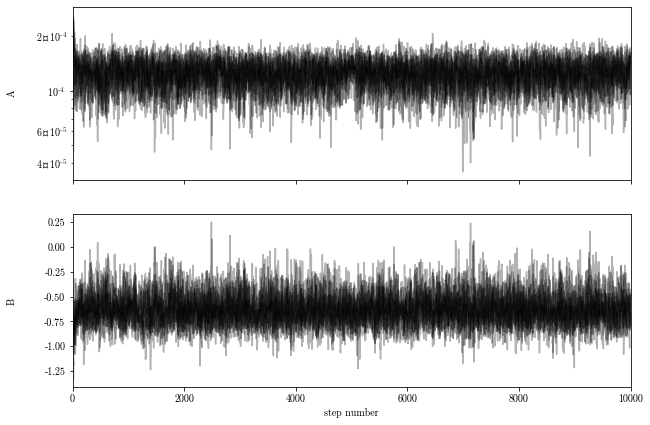

In [233]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "B"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
axes[0].set_yscale('log')
plt.savefig('mcmc_simple_power_chain.png', dpi=200)

In [234]:
sampler.get_log_prob()[:,-1]
list(zip(sampler.get_log_prob()[-1,:], sampler.get_chain()[-1,:]))

[(-7.387436988312833, array([ 1.52738050e-04, -4.82882666e-01])),
 (-5.990298263580455, array([ 1.55009972e-04, -7.28676231e-01])),
 (-6.682040417173116, array([ 9.49968302e-05, -6.51902890e-01])),
 (-5.264100699504449, array([ 1.33041528e-04, -5.46693253e-01])),
 (-5.8596887084060905, array([ 1.31288453e-04, -8.17380252e-01])),
 (-6.44152056372923, array([ 1.62340176e-04, -6.25923739e-01])),
 (-9.463020113894618, array([ 1.58421311e-04, -4.31024769e-01])),
 (-5.011291404154463, array([ 1.34241611e-04, -5.94027633e-01])),
 (-5.650525924663739, array([ 1.51465829e-04, -6.09872985e-01])),
 (-5.979326880771755, array([ 1.51287765e-04, -7.54457447e-01]))]

In [235]:
tau = sampler.get_autocorr_time()
print(tau)

[39.29518547 34.97757478]


In [236]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)

(6330, 2)


<Figure size 432x360 with 0 Axes>

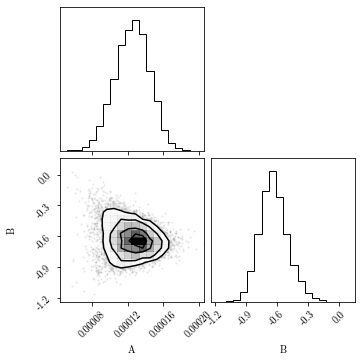

In [237]:
import corner

plt.rc('axes', unicode_minus=False)
plt.figure(figsize=[6,5])
fig = corner.corner(
        flat_samples, labels=labels
);
plt.savefig('popped_corner_plot.png', dpi=300)

In [238]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q  = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.6f}}}^{{{2:.6f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

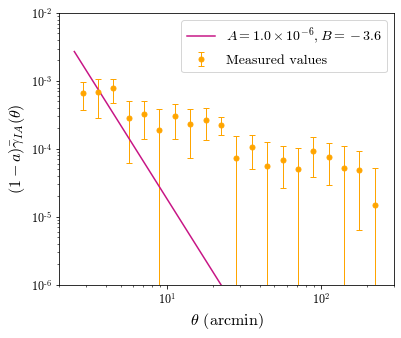

In [246]:
#test parameters to visually idenitify where to intialise walkers (roguhly)
Amp = 1e-6
Beta = -3.6

popped_sig = np.delete(sig, [5,10,12,14,17,19])

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'

plt.figure(figsize=[6,5])
plt.errorbar(theta, data_points, yerr=sig, lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3, label='Measured values')    
plt.plot(thetaX, Amp*(thetaX/theta0)**Beta, label=r'$A = 1.0 \times 10^{-6}, B = -3.6$', color='mediumvioletred')
plt.legend(fontsize=14)
plt.ylim([1e-6, 1e-2])
plt.xlim([2,300])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\theta$ (arcmin)', fontsize=16)
plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}(\theta)$',fontsize=16)    
plt.savefig('Full_data_test.png',dpi=300)

<AxesSubplot:>

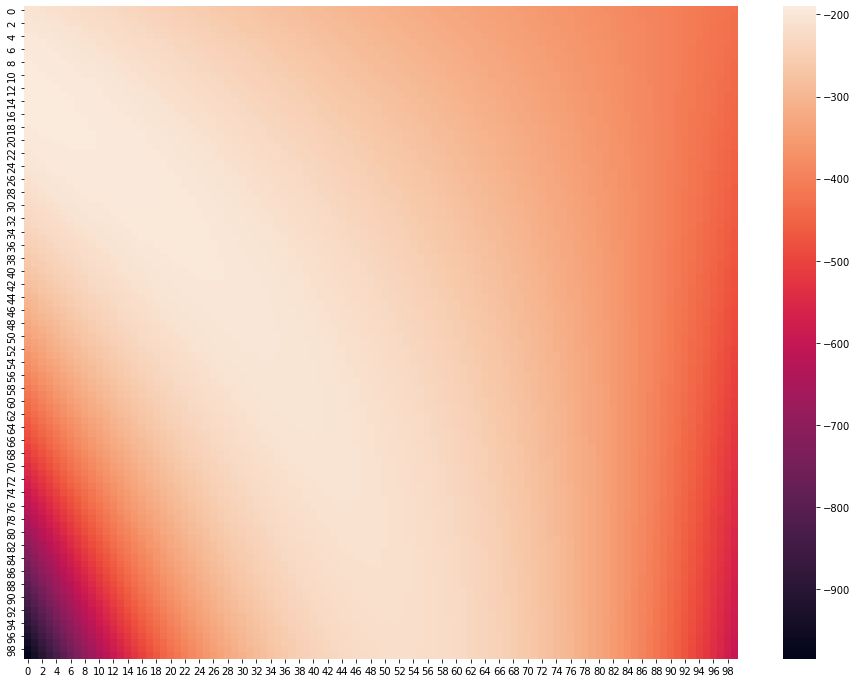

In [185]:
import seaborn as sn

ax_len = 100

A_mid = 2.4e-4
B_mid = -0.7

A_axis = np.linspace(1e-4, 4e-4, ax_len)
B_axis = np.linspace(-1, 0, ax_len)

grid = np.zeros([ax_len,ax_len])

for i in range(len(A_axis)):
    for j in  range(len(B_axis)):
        grid[i,j] = log_probability([A_axis[i], B_axis[j]], theta, data_points, inv_cov)
        
plt.figure(figsize=[16,12])
ax = plt.axes()
sn.heatmap(grid)